In [2]:
# Make own packages auto reload
%load_ext autoreload
%autoreload 2

# Mosaics

In [40]:
import numpy as np

from plot import plot_mosaics
from simulate import simulate_rgc_mosaics

np.random.seed(42)
n_mosaics = 3
center_noise = 0.1  # Position noise
diameter_noise = 0.1

mean_diameters = [10., 12.0, 15.0]  # Mean diameter for each mosaic
n_missing_list = [0, 0, 0]  # Missing cells per mosaic
overlap_factors = [1.1, 1.1, 1.1]  # No overlap, 15% overlap, 10% gaps

# Generate mosaics
groups, polygons, _, clipped = simulate_rgc_mosaics(
    n_mosaics=n_mosaics,
    mean_diameters=mean_diameters,
    center_noise=center_noise,
    diameter_noise=diameter_noise,
    n_missing_list=n_missing_list,
    overlap_factors=overlap_factors,
)

In [41]:
from polygons import compute_polygon_centers

centers = compute_polygon_centers(polygons)

In [42]:
from overlap import compute_iou_matrix

iou_matrix = compute_iou_matrix(polygons)

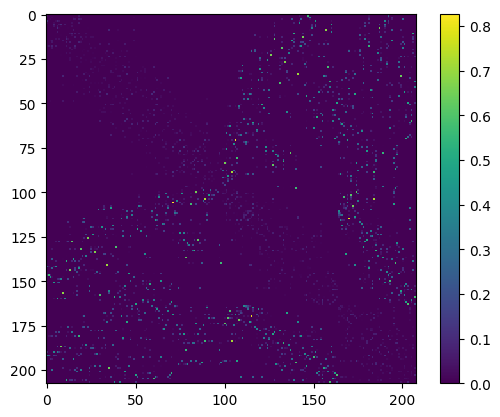

In [43]:
from matplotlib import pyplot as plt

plt.imshow(iou_matrix, interpolation='none')
plt.colorbar()
plt.show()

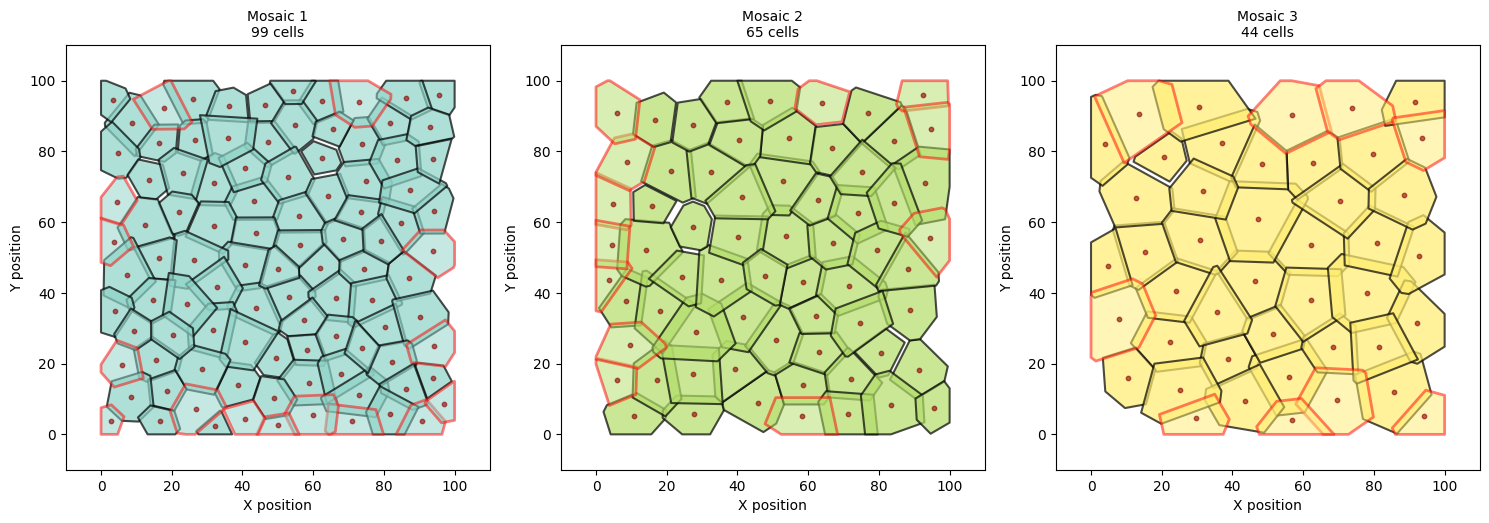

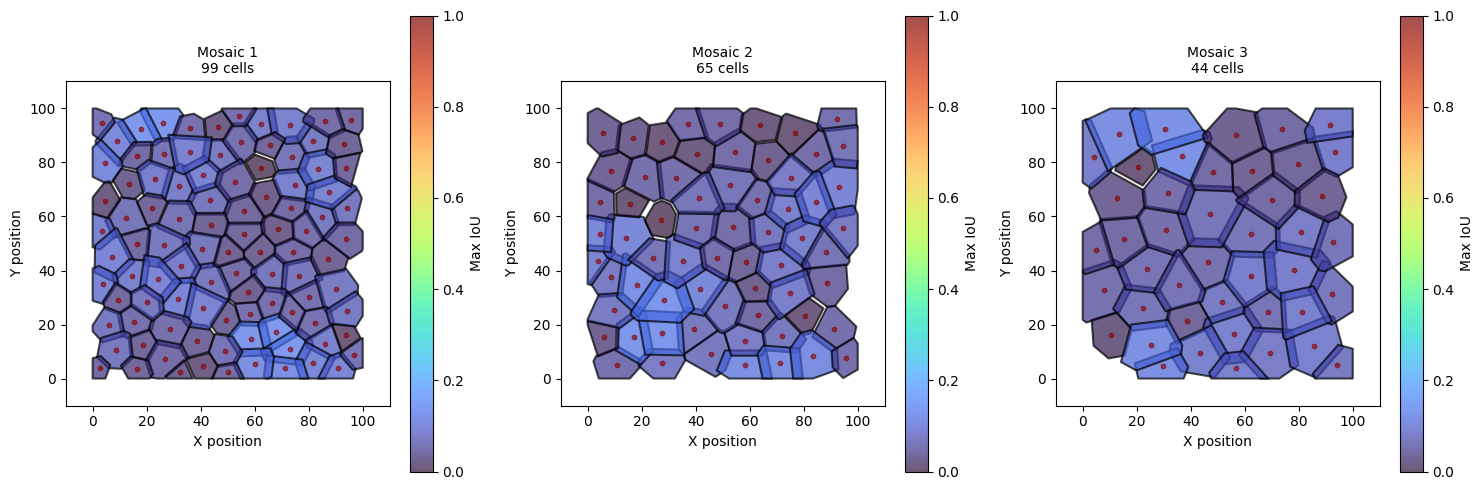

In [44]:
from matplotlib import pyplot as plt

plot_mosaics(groups, polygons, centers, highlight=clipped, mode='basic')
plt.show()

plot_mosaics(groups, polygons, centers, iou_matrix=iou_matrix, highlight=clipped, mode='iou')
plt.show()

# Features

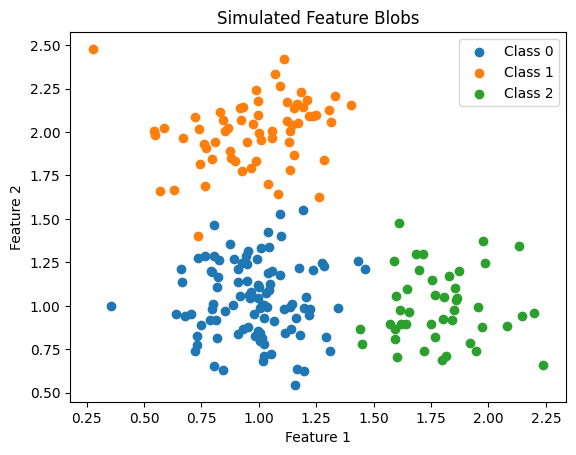

In [7]:
from plot import plot_blobs
from matplotlib import pyplot as plt
import numpy as np

u_groups, n_per_group = np.unique(groups, return_counts=True)
n_groups = len(u_groups)

assert n_groups == 3

feat_centers = [
    (1, 1),
    (1, 2),
    (1.8, 1),
]

feat_stds = [
    (0.2, 0.2),
    (0.2, 0.2),
    (0.2, 0.2),
]

X = []
y = []
for i, n_i in enumerate(n_per_group):
    center_i = feat_centers[i]
    stds_i = feat_stds[i]
    X_i = np.random.normal(center_i, stds_i, size=(n_i, 2))
    X.append(X_i)
    y.append(np.full(n_i, i))

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

plot_blobs(X=X, y=y)

In [8]:
import scanpy as sc

adata = sc.AnnData(X)
sc.pp.scale(adata)
sc.pp.neighbors(adata, n_neighbors=5, use_rep='X')

# Connectivities

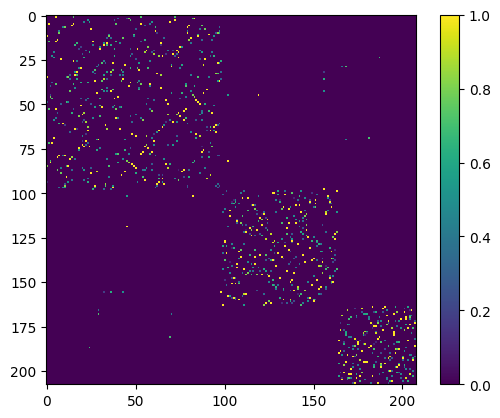

In [9]:
plt.imshow(adata.obsp['connectivities'].toarray(), interpolation='none')
plt.colorbar()
plt.show()

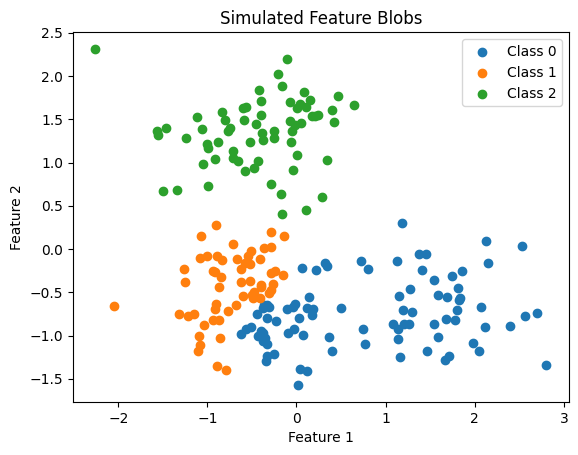

In [10]:
from clustering import find_leiden_resolution

leiden_res = find_leiden_resolution(
    adata, n_groups, adjacency_key='connectivities', key_added='leiden',
    start_res=0.1, tolerance=0, max_iter=20, verbose=False
)
plot_blobs(X=X, y=adata.obs["leiden"])
plt.show()

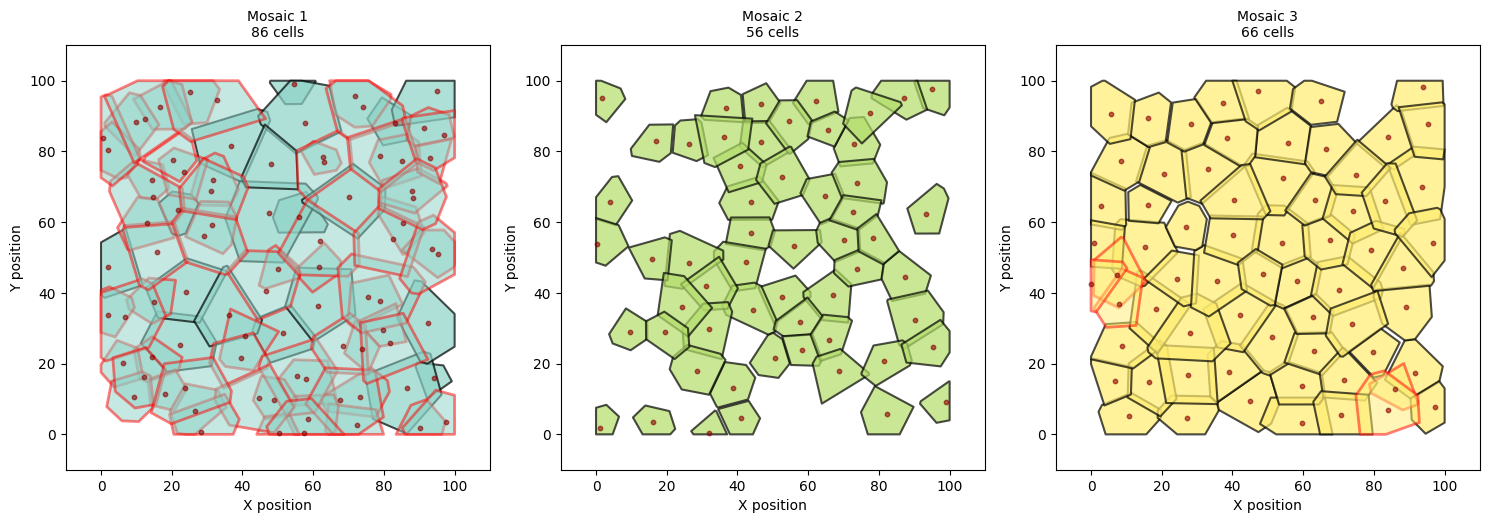

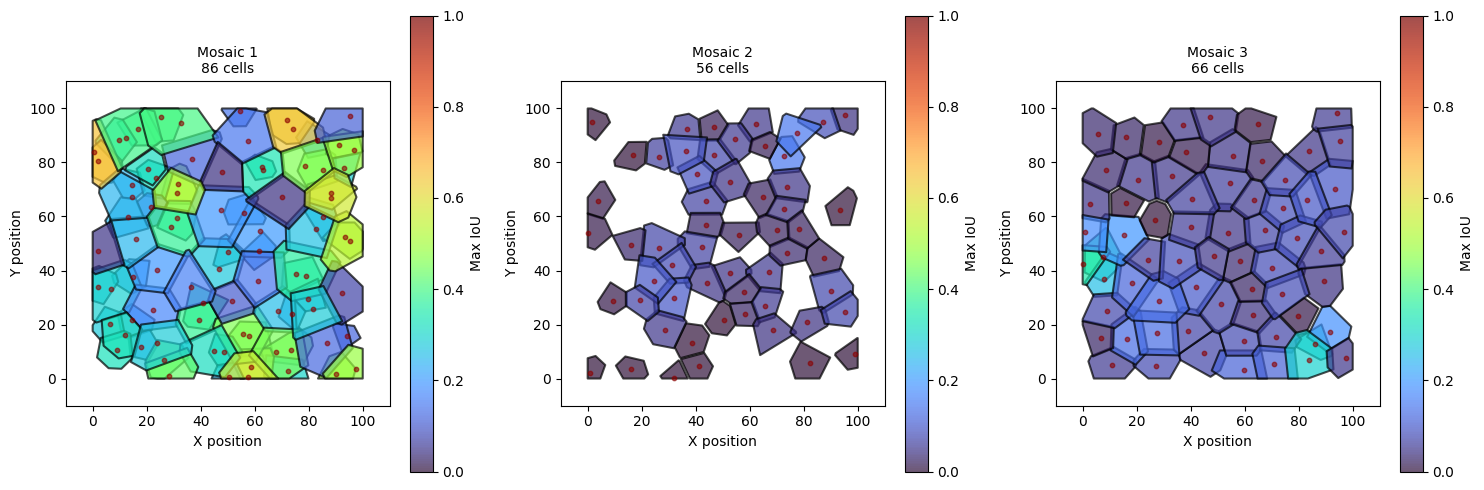

In [11]:
plot_mosaics(adata.obs["leiden"], polygons, centers, mode='violations', iou_matrix=iou_matrix, iou_threshold=0.2)
plt.show()
plot_mosaics(adata.obs["leiden"], polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()

In [12]:
from clustering import apply_mosaic_constraints

repel_threshold = 0.3

# 2. Apply spatial mosaic penalty
adata = apply_mosaic_constraints(
    adata,
    iou_matrix,
    attract_threshold=0.15,
    repel_threshold=repel_threshold,
    attract_weight=2,
    repel_weight=2,
    mode='multiply',
)

In [13]:
diff = adata.obsp['connectivities'].toarray() - adata.obsp['mosaic_connectivities'].toarray()

(diff > 0).sum() / (diff == 0).sum()

np.float64(0.025213270142180094)

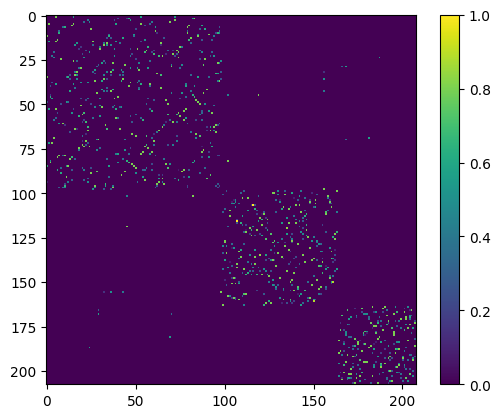

In [14]:
plt.imshow(adata.obsp['mosaic_connectivities'].toarray(), interpolation='none')
plt.colorbar()
plt.show()

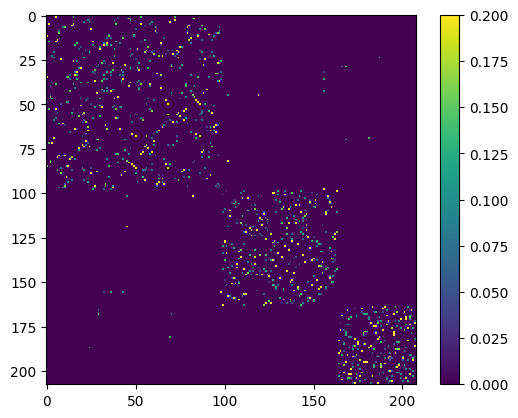

In [15]:
plt.imshow(diff, interpolation='none')
plt.colorbar()
plt.show()

In [16]:
from clustering import find_leiden_resolution

find_leiden_resolution(
    adata, n_groups, adjacency_key='mosaic_connectivities', key_added='leiden_mosaic',
    start_res=leiden_res, tolerance=0, max_iter=20, verbose=False
);

In [17]:
adata.obs["leiden_mosaic"].unique()

['0', '1', '2']
Categories (3, object): ['0', '1', '2']

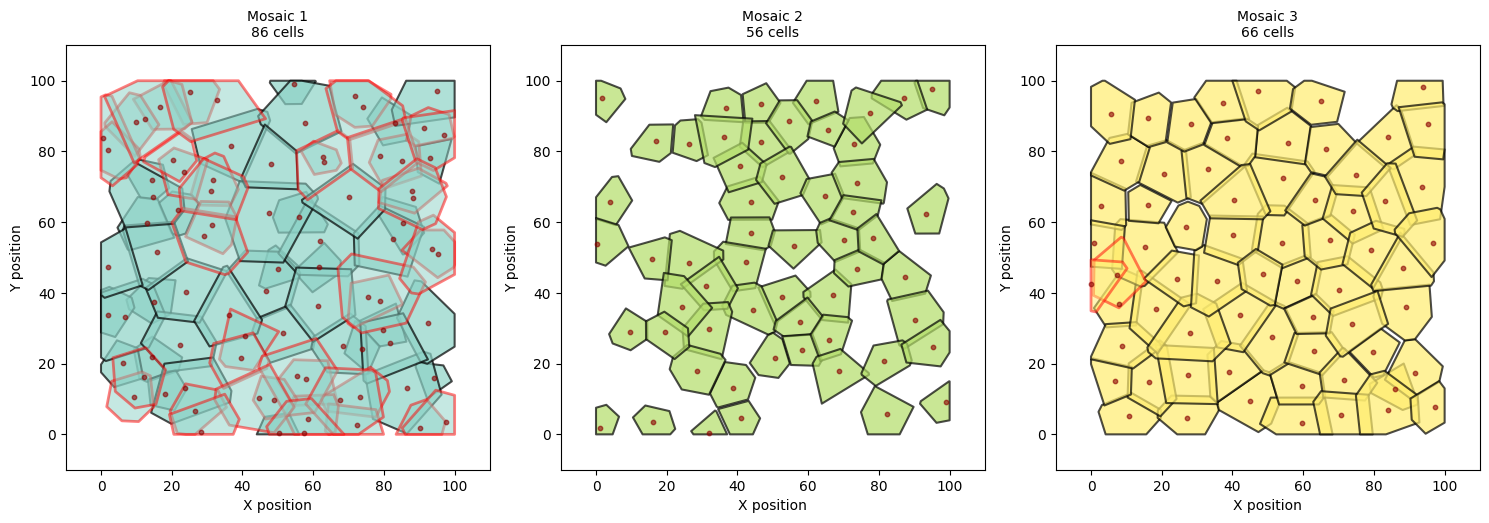

In [18]:
plot_mosaics(adata.obs["leiden"], polygons, centers, mode='violations', iou_matrix=iou_matrix,
             iou_threshold=repel_threshold)
plt.show()

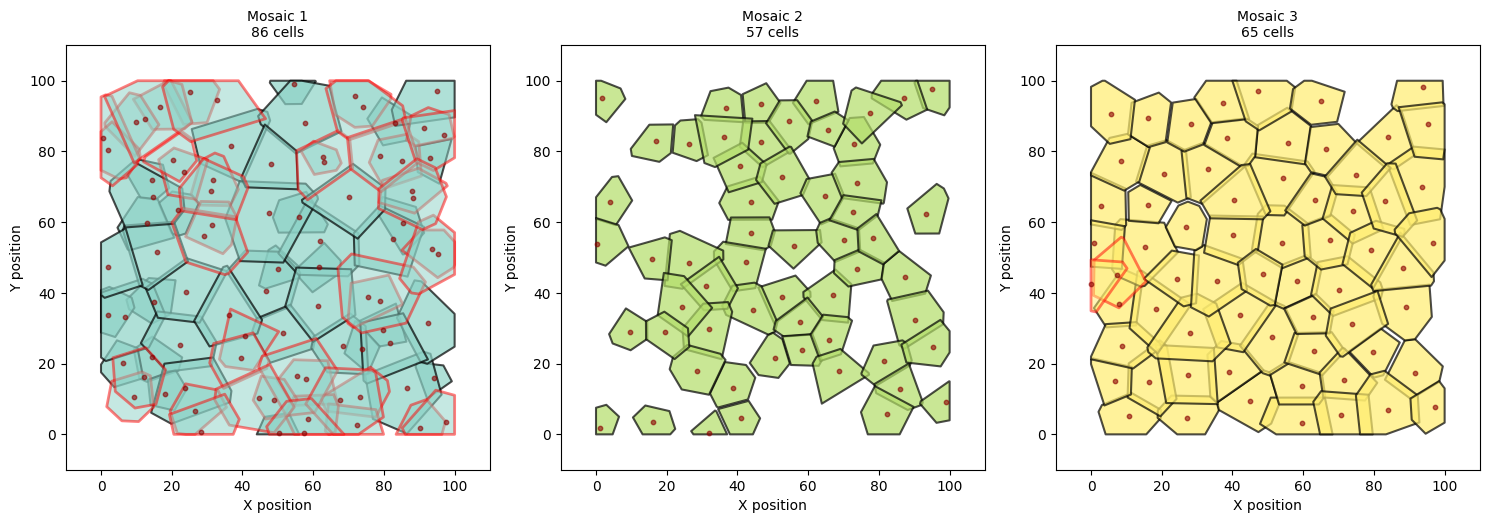

In [19]:
plot_mosaics(adata.obs["leiden_mosaic"], polygons, centers, mode='violations', iou_matrix=iou_matrix,
             iou_threshold=repel_threshold)
plt.show()

In [20]:
from clustering import compare_clustering_mosaic_quality

# 5. Compare mosaic quality
comparison = compare_clustering_mosaic_quality(
    adata,
    iou_matrix,
    standard_key='leiden',
    mosaic_key='leiden_mosaic',
    iou_threshold=repel_threshold,
)

print("\nMosaic Quality Comparison:")
print(comparison.groupby('method')[['mean_iou', 'max_iou', 'violations']].mean())


Mosaic Quality Comparison:
              mean_iou   max_iou  violations
method                                      
Mosaic-aware  0.054866  0.380802         8.0
Standard      0.055532  0.380802         8.0


# Constrained leiden

In [21]:
from constrained_leidenalg import build_feature_knn_graph, find_optimal_resolution, mosaic_leiden_clustering

features = X
positions = centers

G = build_feature_knn_graph(features, k=5)

overlap_penalty = 10  #0.2
overlap_dist = 12

# Find optimal resolution
optimal_res = find_optimal_resolution(
    G, positions,
    target_clusters=(3, 3),
    res_start=0.1,
    res_min=0.001,
    res_max=3.0,
    n_trials=15,
    overlap_dist=overlap_dist,
    overlap_penalty=overlap_penalty,
    n_iterations=10,
    seed=42,
    verbose=True
)

# Run clustering
clusters, partition = mosaic_leiden_clustering(
    G, positions,
    resolution_parameter=optimal_res,
    overlap_dist=overlap_dist,
    overlap_penalty=overlap_penalty,
    n_iterations=10,
    seed=42,
    verbose=True
)

print(f"\nFinal result: {len(np.unique(clusters))} clusters")
cluster_sizes = np.bincount(clusters)
print(f"Cluster sizes: min={cluster_sizes[cluster_sizes > 0].min()}, "
      f"max={cluster_sizes.max()}, "
      f"mean={cluster_sizes[cluster_sizes > 0].mean():.1f}")

# # Optional: enforce contiguity
# clusters_clean = post_process_enforce_contiguity(clusters, positions)
# print(f"After contiguity enforcement: {len(np.unique(clusters_clean))} clusters")
#
# # Analyze quality
# quality = analyze_mosaic_quality(clusters_clean, positions)
# total_overlaps = sum(q['n_overlaps'] for q in quality.values())
# print(f"Total overlapping pairs: {total_overlaps}")

Searching for resolution to get 3-3 clusters...
  Resolution 0.10 -> 5 clusters
  Resolution 0.05 -> 4 clusters
  Resolution 0.03 -> 4 clusters
  Resolution 0.01 -> 3 clusters

✓ Found good resolution: 0.01 gives 3 clusters
Mosaic Leiden Clustering
  Resolution: 0.013375000000000001
  Overlap distance: 12
  Overlap penalty: 10
  Result: 3 clusters

Final result: 3 clusters
Cluster sizes: min=44, max=101, mean=69.3


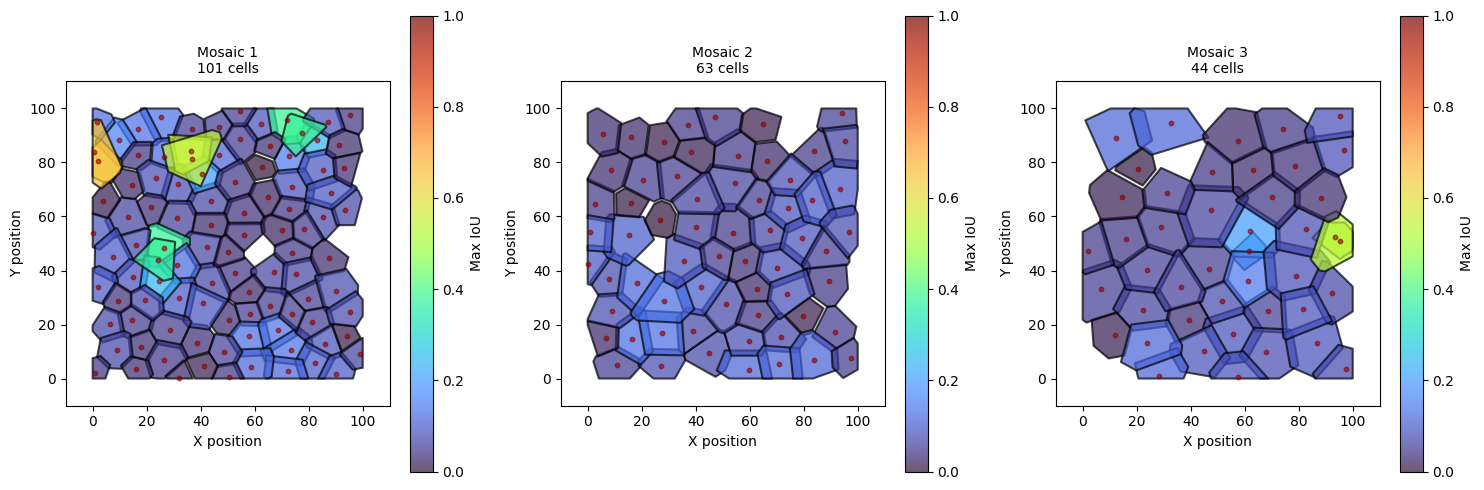

In [22]:
plot_mosaics(clusters, polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()

# Ward

In [23]:
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

print("Compute structured hierarchical clustering...")
st = time.time()
ward_structured = AgglomerativeClustering(
    n_clusters=3, connectivity=connectivity, linkage="ward"
).fit(X)
elapsed_time_structured = time.time() - st
label_structured = ward_structured.labels_
print(f"Elapsed time: {elapsed_time_structured:.2f}s")
print(f"Number of points: {label_structured.size}")

Compute structured hierarchical clustering...
Elapsed time: 0.01s
Number of points: 208


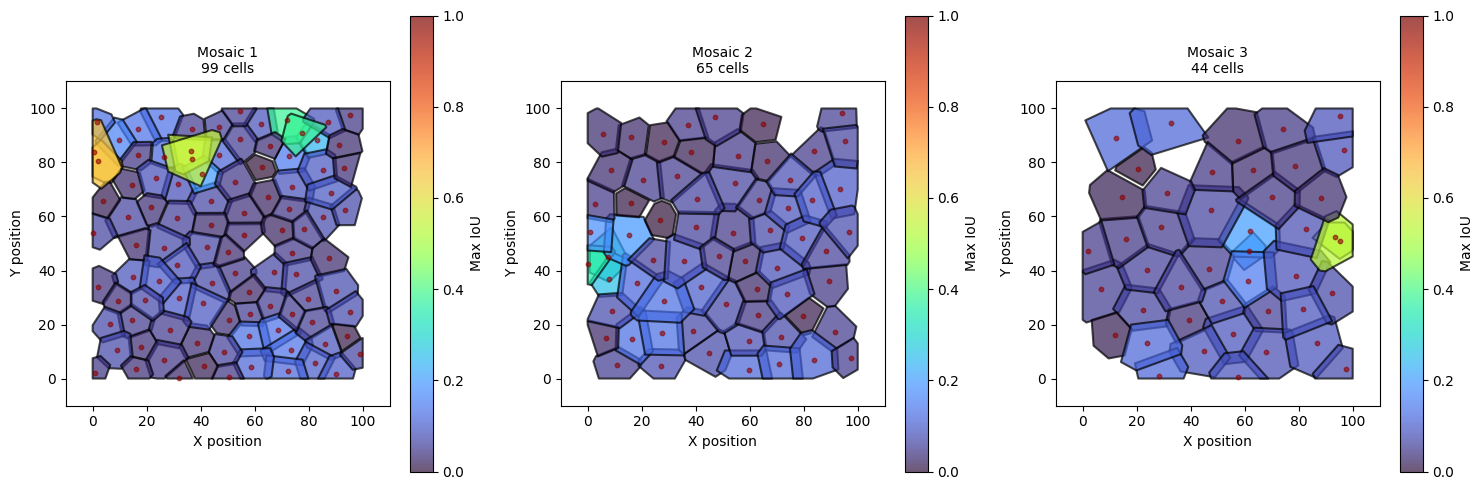

In [24]:
plot_mosaics(label_structured, polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()

# COP k-means

In [26]:
from copkmeans import cop_kmeans

np.random.seed(100)

xs, ys = np.where(iou_matrix > 0.5)
clusters, clust_centers = cop_kmeans(dataset=X, k=3, ml=[], cl=[(int(xi), int(yi)) for xi, yi in zip(xs, ys)])

if not clusters:
    raise ValueError(f"No clusters found")

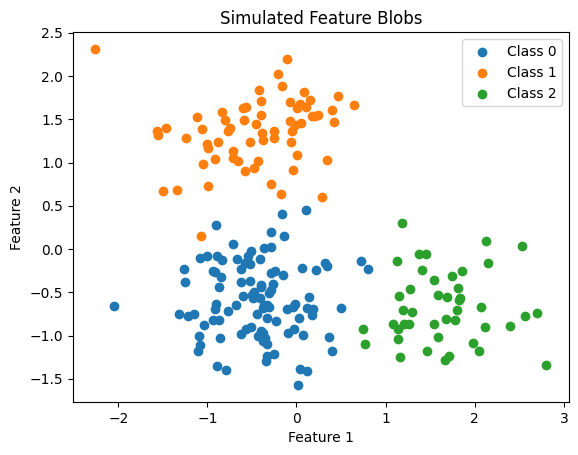

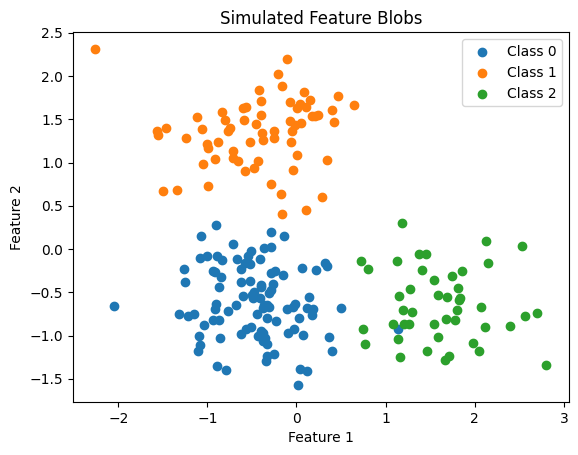

In [27]:
plot_blobs(X=X, y=groups)
plot_blobs(X=X, y=clusters)
plt.show()

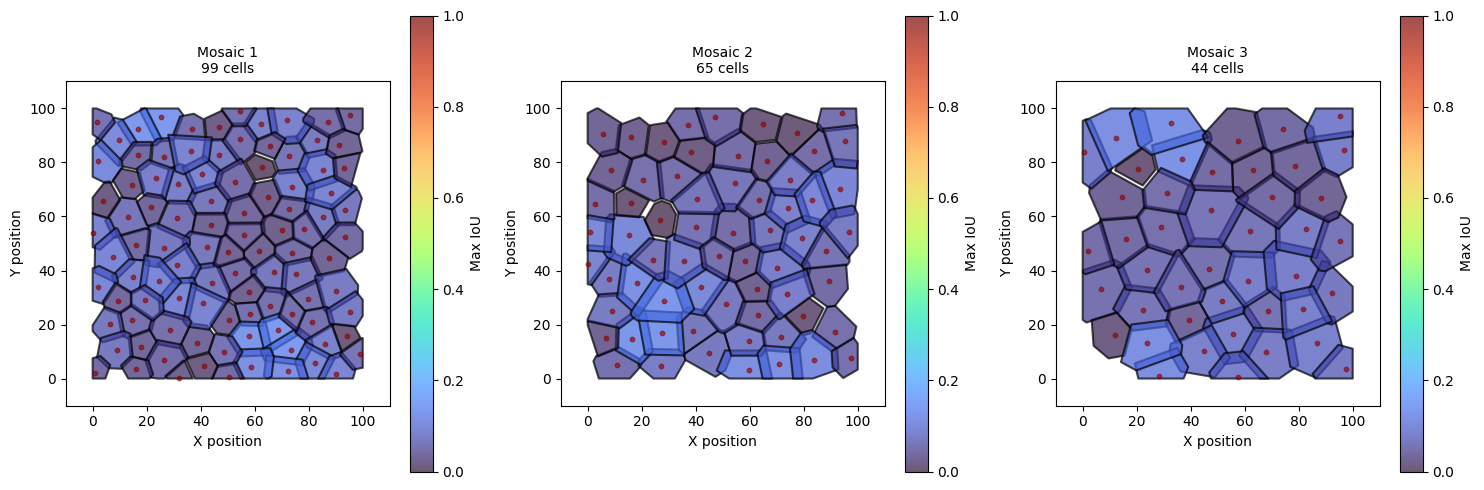

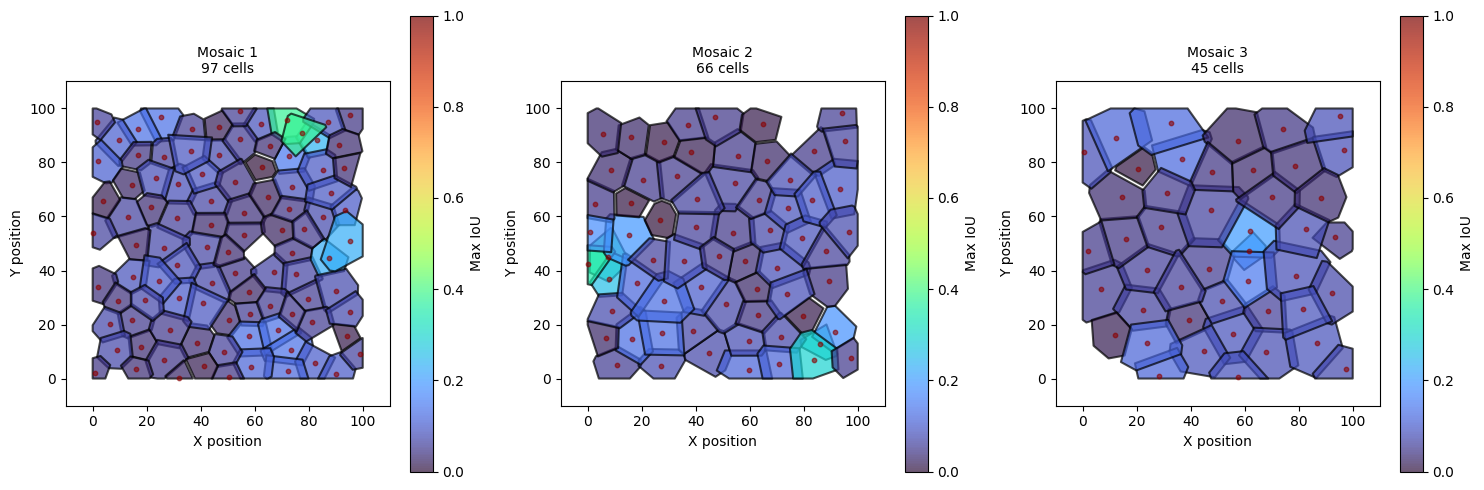

In [28]:
plot_mosaics(groups, polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()

plot_mosaics(np.array(clusters), polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()

# GMM

In [135]:
from sklearn.neighbors import NearestNeighbors
from scipy.special import logsumexp
from scipy.linalg import solve_triangular


def spatial_separation_loss_v2(
        means, covariances, weights, X, positions, min_distance=1.0,
        return_penalty=False, return_responsibilities=False,
        reference_positions=None, reference_responsibilities=None):
    """
    Penalize cells that are close in spatial position (xy) but assigned to same cluster.
    """
    n_samples = X.shape[0]
    n_components = means.shape[0]

    if reference_responsibilities is None:
        # Compute responsibilities (soft cluster assignments) for current X
        # We'll use a local simplified version of responsibility calculation to avoid dependency
        log_prob = np.zeros((n_samples, n_components))
        for k in range(n_components):
            diff = X - means[k]
            if covariances.ndim == 3:  # full
                cov = covariances[k]
                L = np.linalg.cholesky(cov + 1e-6 * np.eye(X.shape[1]))
                log_det = 2 * np.sum(np.log(np.diag(L)))
                y = solve_triangular(L, diff.T, lower=True)
                mahalanobis = np.sum(y ** 2, axis=0)
                log_prob[:, k] = -0.5 * (mahalanobis + log_det + X.shape[1] * np.log(2 * np.pi))
            elif covariances.ndim == 2:  # diag
                cov = covariances[k] + 1e-6
                log_det = np.sum(np.log(cov))
                mahalanobis = np.sum((diff ** 2) / cov, axis=1)
                log_prob[:, k] = -0.5 * (mahalanobis + log_det + X.shape[1] * np.log(2 * np.pi))

            log_prob[:, k] += np.log(weights[k] + 1e-15)

        log_prob_norm = logsumexp(log_prob, axis=1, keepdims=True)
        responsibilities = np.exp(log_prob - log_prob_norm)
    else:
        # If reference_responsibilities matches X, use it.
        # Otherwise (e.g. predicting on new data), we need current responsibilities for total_loss.
        if reference_responsibilities.shape[0] == n_samples:
            responsibilities = reference_responsibilities
        else:
            # Recompute responsibilities for current X (which corresponds to positions)
            log_prob = np.zeros((n_samples, n_components))
            for k in range(n_components):
                diff = X - means[k]
                if covariances.ndim == 3:  # full
                    cov = covariances[k]
                    L = np.linalg.cholesky(cov + 1e-6 * np.eye(X.shape[1]))
                    log_det = 2 * np.sum(np.log(np.diag(L)))
                    y = solve_triangular(L, diff.T, lower=True)
                    mahalanobis = np.sum(y ** 2, axis=0)
                    log_prob[:, k] = -0.5 * (mahalanobis + log_det + X.shape[1] * np.log(2 * np.pi))
                elif covariances.ndim == 2:  # diag
                    cov = covariances[k] + 1e-6
                    log_det = np.sum(np.log(cov))
                    mahalanobis = np.sum((diff ** 2) / cov, axis=1)
                    log_prob[:, k] = -0.5 * (mahalanobis + log_det + X.shape[1] * np.log(2 * np.pi))

                log_prob[:, k] += np.log(weights[k] + 1e-15)

            log_prob_norm = logsumexp(log_prob, axis=1, keepdims=True)
            responsibilities = np.exp(log_prob - log_prob_norm)

    if reference_positions is None:
        reference_positions = positions
        reference_resps = responsibilities
    else:
        reference_resps = reference_responsibilities
        if reference_resps is None:
            # This case shouldn't happen with the way we call it from GMM,
            # but for completeness we'd need to compute it for reference_positions too.
            raise ValueError("reference_responsibilities must be provided if reference_positions is provided")


    # Get hard cluster assignments
    hard_assignments = np.argmax(reference_resps, axis=1)

    # Use KDTree for efficient neighbor search
    nn = NearestNeighbors(radius=min_distance, n_neighbors=len(positions))
    nn.fit(reference_positions)
    distances, indices = nn.radius_neighbors(positions)

    # Get median nearest neighbor distance per cluster
    median_nn_distances = np.zeros(n_components)

    for j in range(n_components):
        # Get all points in this cluster
        cluster_mask = hard_assignments == j
        cluster_point_indices = np.where(cluster_mask)[0]

        if len(cluster_point_indices) == 0:
            median_nn_distances[j] = min_distance
            continue

        # Collect nearest neighbor distances within this cluster
        nn_distances_in_cluster = []

        for i in cluster_point_indices:
            neighbor_indices = indices[i]
            neighbor_distances = distances[i]

            # Remove self if comparing with same set
            if reference_positions is positions:
                mask = neighbor_indices != i
                neighbor_indices = neighbor_indices[mask]
                neighbor_distances = neighbor_distances[mask]

            # Filter to only neighbors in the same cluster
            neighbor_in_cluster_mask = np.isin(neighbor_indices, cluster_point_indices)
            neighbor_indices_in_cluster = neighbor_indices[neighbor_in_cluster_mask]
            neighbor_distances_in_cluster = neighbor_distances[neighbor_in_cluster_mask]

            # Get first (nearest) neighbor within cluster if exists
            if len(neighbor_indices_in_cluster) > 0:
                nn_distances_in_cluster.append(neighbor_distances_in_cluster[0])

        # Compute median distance for this cluster
        if len(nn_distances_in_cluster) > 0:
            median_nn_distances[j] = np.median(nn_distances_in_cluster)
        else:
            median_nn_distances[j] = min_distance


    # Compute penalty matrix based on deviation from expected distances
    penalty_matrix = np.zeros((n_samples, n_components))

    for i in range(n_samples):
        neighbor_indices = indices[i]
        neighbor_distances = distances[i]

        # Remove self if we are comparing with the same set
        if reference_positions is positions:
            mask = neighbor_indices != i
            neighbor_indices = neighbor_indices[mask]
            neighbor_distances = neighbor_distances[mask]

        # For each cluster k: check deviation from expected distance
        for k in range(n_components):
            # Get points in cluster k
            cluster_mask = hard_assignments == k
            cluster_point_indices = np.where(cluster_mask)[0]

            if len(cluster_point_indices) == 0:
                continue

            # Filter to only neighbors in cluster k
            neighbor_in_cluster_mask = np.isin(neighbor_indices, cluster_point_indices)
            neighbor_distances_in_cluster = neighbor_distances[neighbor_in_cluster_mask]

            # Get nearest neighbor distance within this cluster
            if len(neighbor_distances_in_cluster) > 0:
                nearest_dist_in_cluster = neighbor_distances_in_cluster[0]
                expected_dist = median_nn_distances[k]

                # Penalize deviation from expected distance
                # Option 1: Penalize both too close and too far
                deviation = abs(nearest_dist_in_cluster - expected_dist)

                # Option 2: Only penalize when too close (enforce minimum spacing)
                # deviation = max(0, expected_dist - nearest_dist_in_cluster)

                penalty_matrix[i, k] = deviation

    # total_loss = sum_i sum_k (resp_i,k * penalty_matrix_i,k)
    total_loss = np.sum(responsibilities * penalty_matrix)

    # Normalize
    total_loss /= (n_samples * (n_samples - 1)) if n_samples > 1 else 1.0

    if return_penalty and return_responsibilities:
        return total_loss, penalty_matrix, responsibilities
    elif return_penalty:
        return total_loss, penalty_matrix
    elif return_responsibilities:
        return total_loss, responsibilities

    return total_loss


In [144]:
from gmm import SpatialAwareGMM, spatial_separation_loss

gmm_spatial_balanced = SpatialAwareGMM(
    n_components=3,
    covariance_type='full',
    spatial_loss_weight=2.0,
    min_spatial_distance=5,
    additional_loss_fn=None,
    additional_loss_weight=0.0,
    spatial_loss_fn=spatial_separation_loss_v2,
    spatial_inference_weight=2,
    max_iter=10,
)
init_means, init_covs, init_weights = gmm_spatial_balanced.params_from_labels(
    X, groups)

In [145]:
loss, loss_matrix, responsibilities = spatial_separation_loss(
    init_means, init_covs, init_weights, X, centers, return_penalty=True, return_responsibilities=True)

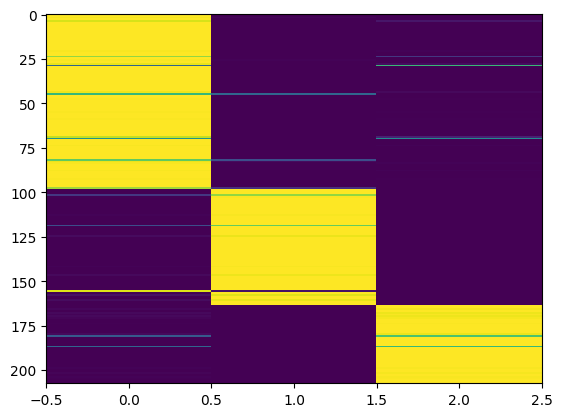

In [146]:
plt.imshow(responsibilities, aspect='auto', interpolation='none');

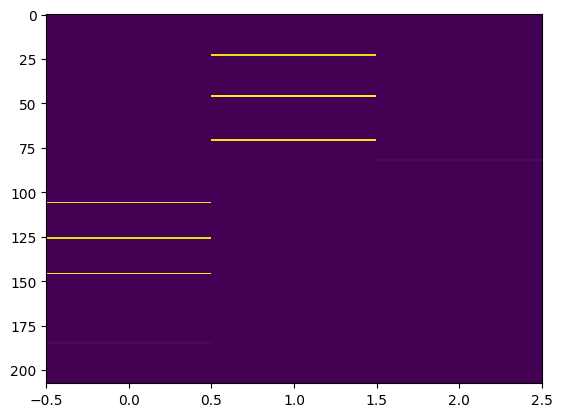

In [147]:
plt.imshow(loss_matrix, aspect='auto', interpolation='none');

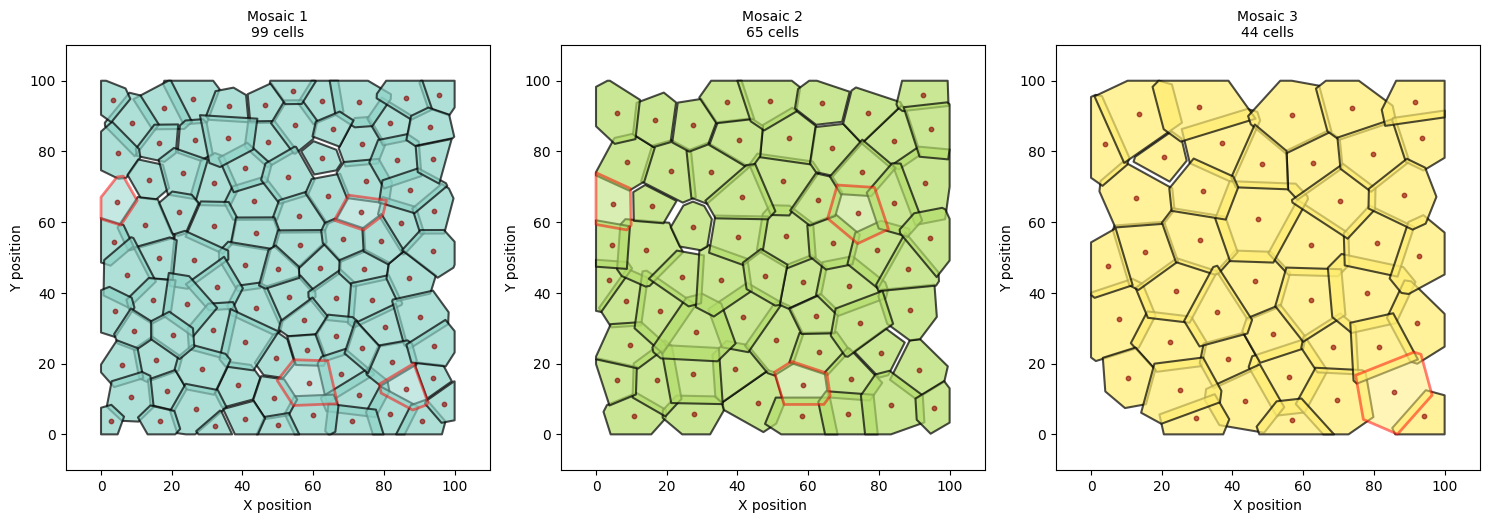

In [148]:
plot_mosaics(groups, polygons, centers, highlight=np.any(loss_matrix > 0, axis=1))
plt.show()

In [149]:
clusters = gmm_spatial_balanced.fit_predict(
    X, positions, fit_kws=dict(init_means=init_means, init_covs=init_covs, init_weights=init_weights))

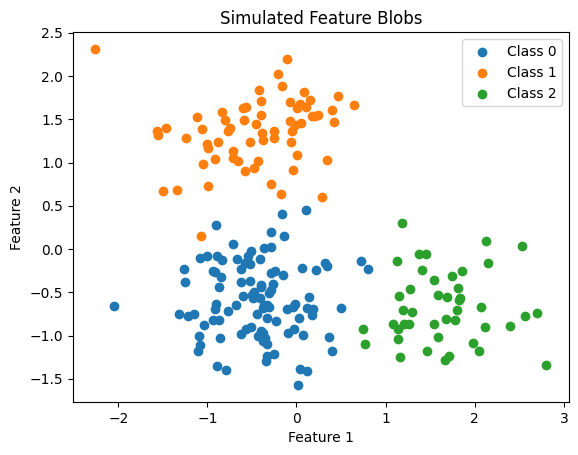

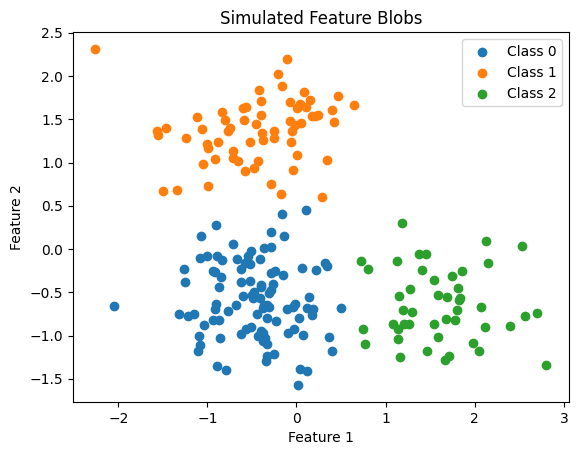

In [150]:
plot_blobs(X=X, y=groups)
plot_blobs(X=X, y=clusters)
plt.show()

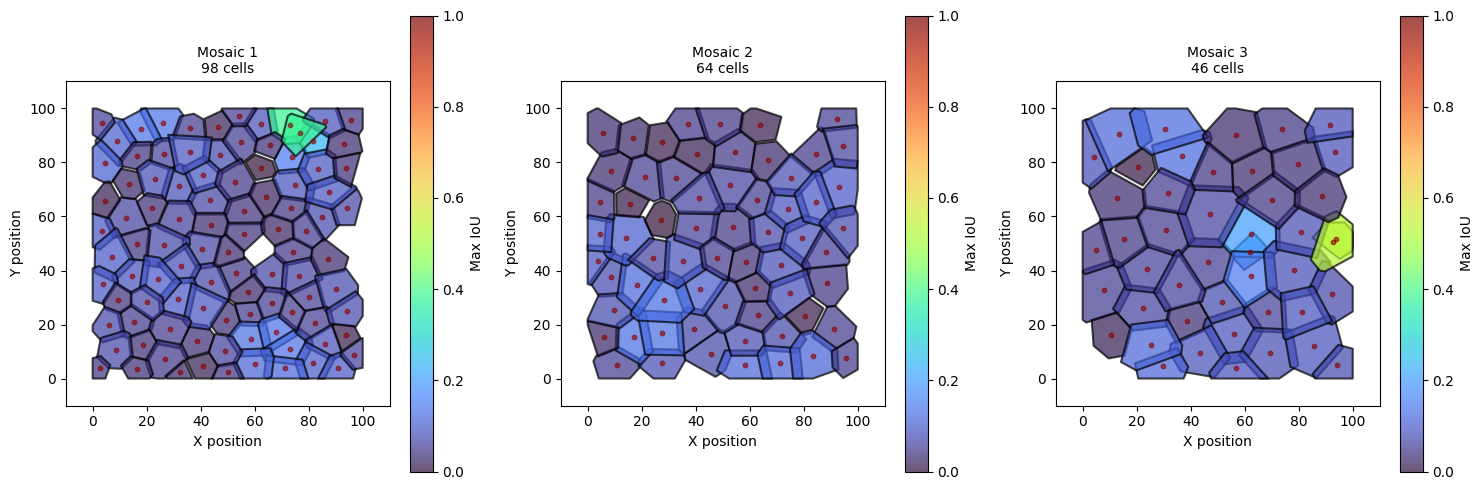

In [151]:
plot_mosaics(clusters, polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()